# **Capstone Project: London Transport Policy Analysis**
## **Models for 2011 Dataset**
## Andrea Broaddus

### **This notebook has three sections:**

**1**.   Baseline Logistic Regression Model and Feature Selection

**2**.   Comparison of Random Forest Classifiers Correcting for Imbalanced Dataset

*     Model 1. Random Forest Baseline, no correction for imbalanced classes
*   Model 2. Random Forest with Oversampling
*   Model 3. Random Forest with Class Weights

  
**3**.   Neural Network Models

*   Testing Optimization Algorithms
*   Hyperparameter Tuning

In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, chi2, f_regression
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the 2011 feature dataset
X11 = pd.read_csv('/content/drive/MyDrive/MLAI_Haas/Capstone/X11.csv')
X11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4765 entries, 0 to 4764
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   afm_firms_2011       4765 non-null   float64
 1   bizsup_firms_2011    4765 non-null   float64
 2   car_time_2011        4765 non-null   float64
 3   comtelrd_firms_2011  4765 non-null   float64
 4   creative_firms_2011  4765 non-null   float64
 5   cult_firms_2011      4765 non-null   float64
 6   devel_firms_2011     4765 non-null   float64
 7   eduhsw_firms_2011    4765 non-null   float64
 8   jobs_2011            4765 non-null   float64
 9   large_firms_2011     4765 non-null   float64
 10  med_firms_2011       4765 non-null   float64
 11  mgmt_firms_2011      4765 non-null   float64
 12  micro_firms_2011     4765 non-null   float64
 13  pop_2011             4765 non-null   float64
 14  pt_time_2011         4765 non-null   float64
 15  pubutil_firms_2011   4765 non-null   f

In [4]:
#Load the target dataset
y = pd.read_csv('/content/drive/MyDrive/MLAI_Haas/Capstone/y.csv')
y.value_counts()

,count
cc,
0,4672
1,93


In [5]:
#Split the data into train and test sets
X11_train, X11_test, y_train, y_test = train_test_split(X11, y, test_size=0.3, random_state = 42)
print(X11_train.shape)
print(y_train.shape)
print(X11_test.shape)
print(y_test.shape)

(3335, 23)
(3335, 1)
(1430, 23)
(1430, 1)


In [6]:
y_train.value_counts()

,count
cc,
0,3270
1,65


In [ ]:
y_test.value_counts()

# **1. Baseline Logistic Regression Model**

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1402
           1       0.17      0.79      0.28        28

    accuracy                           0.92      1430
   macro avg       0.58      0.86      0.62      1430
weighted avg       0.98      0.92      0.95      1430



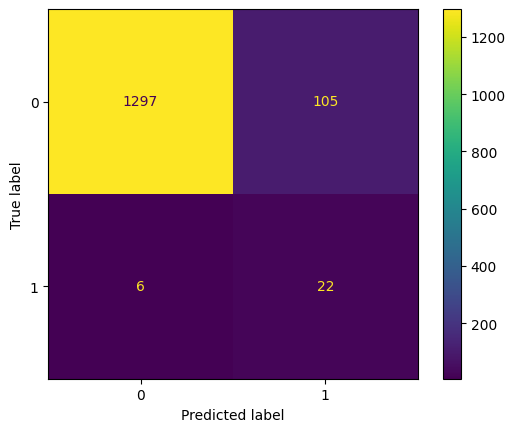

In [7]:
#Estimate a baseline Logistic Regression model
random_seed = 42
lr01=LogisticRegression(class_weight='balanced').fit(X11_train, y_train)
lr01_train_preds = lr01.predict(X11_train)
lr01_test_preds = lr01.predict(X11_test)
lr01_report = classification_report(y_test, lr01_test_preds)
print(lr01_report)
ConfusionMatrixDisplay.from_predictions(y_test, lr01_test_preds)

<Axes: ylabel='Feature'>

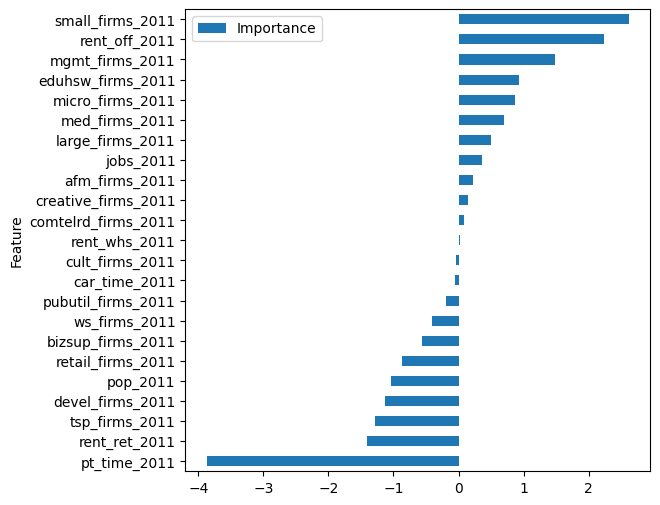

In [8]:
# Access the coefficients from the fitted estimator
coefficients_01 = lr01.coef_[0]

# Get the feature names
feature_names_01 = X11_train.columns

#Plot coefficients in order of importance
feature_importance_01 = pd.DataFrame({'Feature': feature_names_01, 'Importance': np.float64(coefficients_01)})
feature_importance_01 = feature_importance_01.sort_values('Importance', ascending=True)
feature_importance_01.plot(x='Feature', y='Importance', kind='barh', figsize=(6,6))

## **Feature Selection**


In [9]:
#Use Select from Model tool with logistic regression to identify most valuable features
from sklearn.feature_selection import SelectFromModel
random_seed = 42
lr01_select = SelectFromModel(LogisticRegression(C = .1, penalty = 'l1', solver = 'liblinear', class_weight='balanced', random_state = 42))
lr01_select.fit_transform(X11_train, y_train)
lr01_select_model = SelectFromModel(lr01_select, prefit=True)

<Axes: ylabel='Feature'>

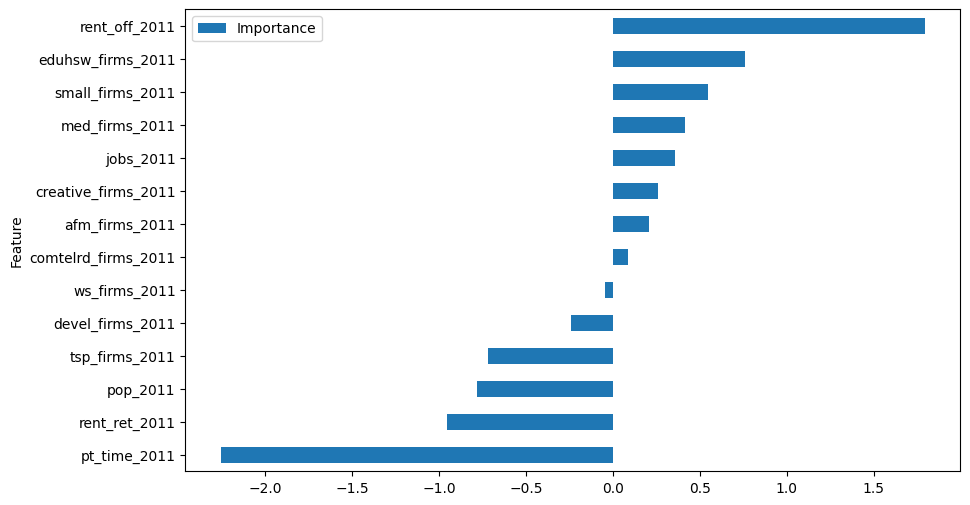

In [10]:
# Access the coefficients from the fitted estimator
coefficients = lr01_select.estimator_.coef_[0]

# Assuming X_train is a pandas DataFrame with column names
# Get the feature names from X_train.columns
feature_names = X11_train.columns

# Use get_support to get a boolean mask of the selected features
support = lr01_select.get_support()

# Get the selected feature names
selected_features = feature_names[support]

# Get the coefficients corresponding to the selected features
selected_coefficients = coefficients[support]

#Plot coefficients in order of importance
feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': np.float64(selected_coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

# **2. Comparison of Classifiers Correcting for Imbalanced Dataset**

This is a highly imbalanced dataset, with the target (positive) case only 2%. We will test three methods of correcting for imbalance and improving model preditive power.

Two methods of correcting for an imbalanced target class were compared to a baseline Random Forest Classifier model using default settings. Each model was scored using stratified k-fold validation, and GridSearchCV was used for hyperparameter tuning.


*   Model 1. Random Forest Baseline, no correction for imbalanced classes
*   Model 2. Random Forest with Oversampling
*   Model 3. Random Forest with Class Weights

•	Balancing class weights. The model parameter class_weight is set to “balanced,” meaning the classes will be weighted in the loss function inversely proportional to their frequency in the dataset. The estimator works to minimize the error on the more heavily weighted positive target class.

•	Oversampling from the target class. The target feature is sampled to create a “balanced” dataset with 50% positive and negative cases, prior to running the estimator. In this method the negative cases are undersampled.


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, DetCurveDisplay

Recall: The ability of a model to find all the relevant cases within a data set. The number of true positives divided by the number of true positives plus the number of false negatives.

In most high-risk detection cases (like cancer), recall is a more important evaluation metric than precision.

In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed to genuine transaction, which is detrimental. In this use case, false positives (a genuine transaction as fraud-positive) are not as important as preventing a fraud.

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

### **Model 1. Random Forest Baseline, no correction for imbalanced classes**

In [12]:
#Baseline model with Random Forest classifier and no correction for class weights

random_seed = 42
kf = StratifiedKFold(n_splits=5, shuffle=False)
rf = RandomForestClassifier(n_estimators=100, random_state=13)
score = cross_val_score(rf, X11_train, np.ravel(y_train,order='C'), cv=kf, scoring='recall', verbose=0)

print("Training Cross Validation Recall scores are: {}".format(score))
print("Training Average Cross Validation Recall score: {}".format(score.mean()))

Training Cross Validation Recall scores are: [0.         0.46153846 0.30769231 0.30769231 0.61538462]
Training Average Cross Validation Recall score: 0.3384615384615385


In [13]:
#Hyperparameter Tuning Using GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf,
                          scoring='recall').fit(X11_train,np.ravel(y_train,order='C'))

print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 10, 'n_estimators': 200, 'random_state': 13}
Best score: 0.3692307692307692


AUC-ROC Curve for Random Forest with No Under/Oversampling: 0.6425


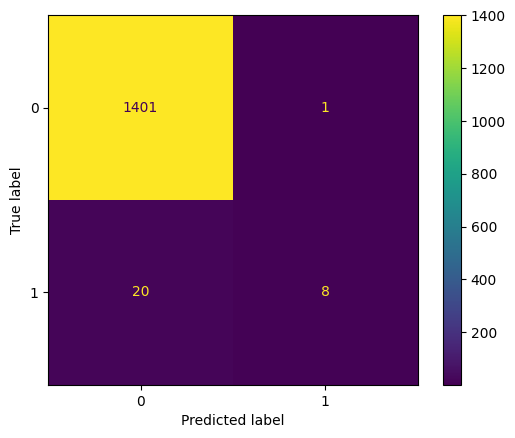

In [14]:
#Evaluation Metrics
random_seed = 42
y_pred = grid_rf.predict(X11_test)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with No Under/Oversampling: {ROCAUCscore:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [15]:
#Summary table

ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.285714,0.888889,0.432432,0.985315


### **Model 2. Random Forest with Oversampling**

In [22]:
#Random Oversampling using imbalanced learning pipeline
from imblearn.over_sampling import RandomOverSampler

#Define oversampling strategy
ros = RandomOverSampler(random_state=42)

#Fit and apply the transform
X_over, y_over = ros.fit_resample(X11_train, y_train)

print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

# Convert y_over to a 1D array before creating a Pandas Series
#y_over = y_over.ravel() # or y_over = y_over.values.flatten()

# Convert y_over to a Pandas Series to use value_counts()
#y_over_series = pd.Series(y_over)

# Use y_over_series for value_counts()
#print('Actual:', y_over_series.value_counts()[0], '/', round(y_over_series.value_counts()[0]/len(y_over_series) * 100,2), '% of the dataset')
#print('Oversampled:', y_over_series.value_counts()[1], '/',round(y_over_series.value_counts()[1]/len(y_over_series) * 100,2), '% of the dataset')

Genuine: 3270 / 50.0 % of the dataset
Frauds: 3270 / 50.0 % of the dataset


In [23]:
#Imbalanced Learning Pipeline
from imblearn.pipeline import Pipeline, make_pipeline

#Define and train the model
random_seed = 42
kf = StratifiedKFold(n_splits=5, shuffle=False)
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))

#Score the model
score2 = cross_val_score(random_overs_pipeline, X11_train, y_train, scoring='recall', cv=kf)

print("Training Cross Validation Recall Scores are: {}".format(score2))
print("Training Average Cross Validation Recall score: {}".format(score2.mean()))

Training Cross Validation Recall Scores are: [0.07692308 0.61538462 0.46153846 0.30769231 0.69230769]
Training Average Cross Validation Recall score: 0.43076923076923074


In [24]:
#Use GridSearch to tune the hyperparameters
random_seed = 42
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over_rf.fit(X11_train, y_train)

print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 13}
Best score: 0.8153846153846155


AUC-ROC Curve for Random Forest with Random Oversampling: 0.9211


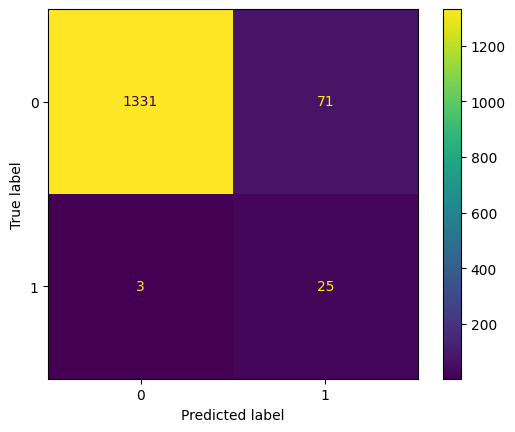

In [25]:
#Evaluation Metrics
random_seed = 42
y_pred = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X11_test)

over_rf_Recall = recall_score(y_test, y_pred)
over_rf_Precision = precision_score(y_test, y_pred)
over_rf_f1 = f1_score(y_test, y_pred)
over_rf_accuracy = accuracy_score(y_test, y_pred)

ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Random Oversampling: {ROCAUCscore:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [26]:
#Summary table
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_rf_accuracy)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.892857,0.260417,0.403226,0.948252


### **Model 3. Random Forest with Class Weights**

In [27]:
#Define Random Forest classifier using class weight parameter
random_seed = 42
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

#Score the model
score5 = cross_val_score(rfb, X11_train, y_train, cv=kf, scoring='recall')

print("Training Cross Validation Recall scores are: {}".format(score5))
print("Training Average Cross Validation Recall score: {}".format(score5.mean()))

Training Cross Validation Recall scores are: [0.         0.38461538 0.23076923 0.23076923 0.46153846]
Training Average Cross Validation Recall score: 0.2615384615384616


In [28]:
#Use GridSearch to tune the hyperparameters
random_seed = 42
grid_rfb = GridSearchCV(rfb, param_grid=params, cv=kf,
                          scoring='recall').fit(X11_train, y_train)

print('Best parameters:', grid_rfb.best_params_)
print('Best score:', grid_rfb.best_score_)

Best parameters: {'max_depth': 4, 'n_estimators': 50, 'random_state': 13}
Best score: 0.7692307692307693


AUC-ROC Curve for Random Forest with Class Weights: 0.9057


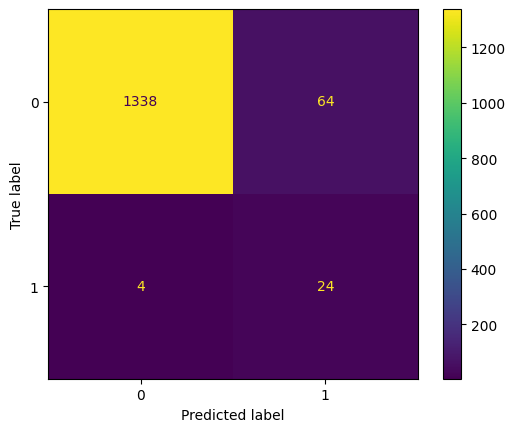

In [29]:
#Evaluation metrics
random_seed = 42
y_pred = grid_rfb.predict(X11_test)

grid_rfb_Recall = recall_score(y_test, y_pred)
grid_rfb_Precision = precision_score(y_test, y_pred)
grid_rfb_f1 = f1_score(y_test, y_pred)
grid_rfb_accuracy = accuracy_score(y_test, y_pred)

ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class Weights: {ROCAUCscore:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [30]:
#Summary table
ndf = [(grid_rfb_Recall, grid_rfb_Precision, grid_rfb_f1, grid_rfb_accuracy)]

grid_rfb_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rfb_score.insert(0, 'Random Forest with', 'Class weights')
grid_rfb_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Class weights,0.857143,0.272727,0.413793,0.952448


In [31]:
#Final summary table
predictions = pd.concat([rf_score, over_rf_score, grid_rfb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Random Forest with,Recall,Precision,F1 Score,Accuracy
1,Random Oversampling,0.892857,0.260417,0.403226,0.948252
2,Class weights,0.857143,0.272727,0.413793,0.952448
0,No Under/Oversampling,0.285714,0.888889,0.432432,0.985315


## **Visulazation of Results**

TypeError: 'DataFrame' object is not callable

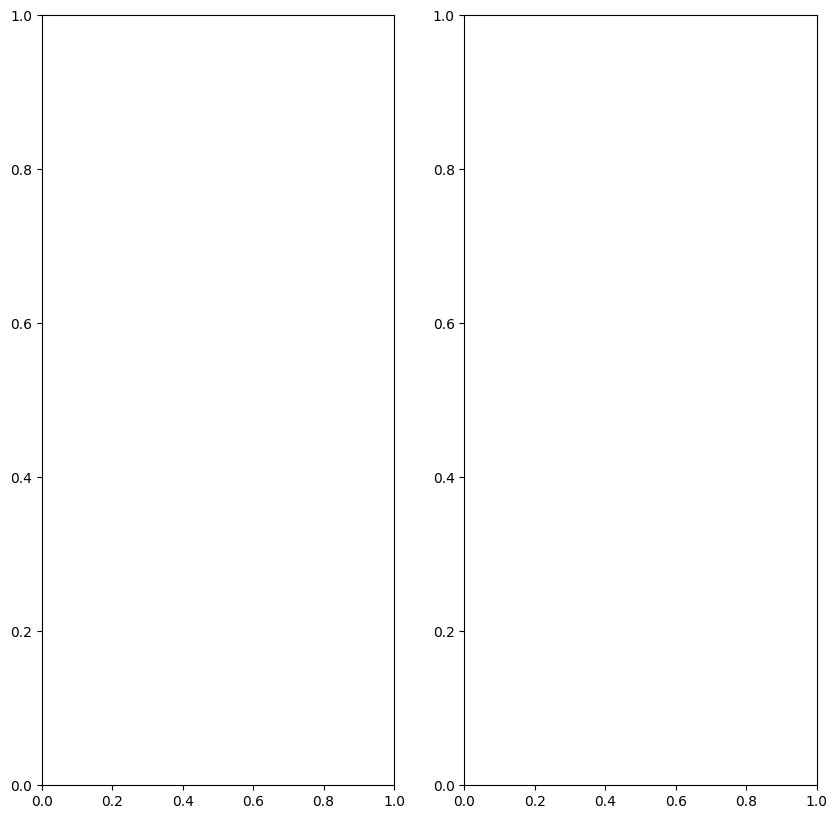

In [33]:
#Plot of ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
ax_roc, ax_pr = axes[0], axes[1]

classifiers = {
    "Random Forest": grid_rf,
    "Random Forest with Over Sampling": grid_over_rf,
    "Random Forest with Class weights": grid_rfb}

for name, clf in classifiers.items():
    clf.fit(X11_train, y_train)
    RocCurveDisplay.from_estimator(clf, X11_test, y_test(), ax=ax_roc, name=name)
    PrecisionRecallDisplay.from_estimator(clf, X11_test, y_test(), ax=ax_pr, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_pr.set_title("Precision Recall curves")
plt.legend()
plt.show()

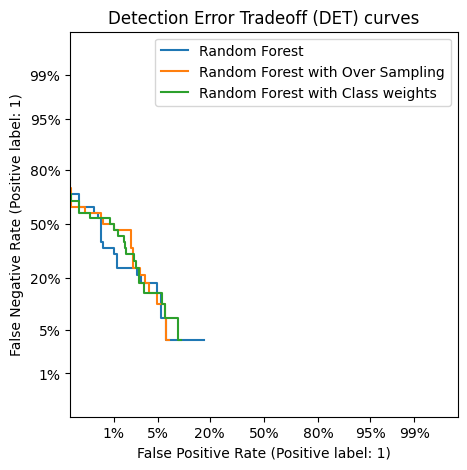

In [34]:
#Plot of Detection-Error curve
fig, axes = plt.subplots(1, 1, figsize=(5,5))
ax_det = axes
classifiers = {
    "Random Forest": grid_rf,
    "Random Forest with Over Sampling": grid_over_rf,
    "Random Forest with Class weights": grid_rfb,
        # Add more classifiers here if needed }
}
for name, clf in classifiers.items():
    clf.fit(X11_train, y_train)
    DetCurveDisplay.from_estimator(clf, X11_test, y_test, ax=ax_det, name=name)

ax_det.set_title("Detection Error Tradeoff (DET) curves")
plt.legend()
plt.show()

## **Findings**

#**Neural Network**



In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [36]:
!pip install scikeras

In [37]:
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import Recall, FalseNegatives, AUC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score


## **Baseline Neural Network**

Define a baseline neural network with two layers, one with 100 neurons and a Relu activation function, and an output layer with a Sigmoid activation function.

The binary cross-entropy loss function and recall scoring method selected for as best suited for a binary classification with imbalanced data.

It isn't obvious which optimizer is best suited to this problem, so we will test three from the Keras libary on the base line model using default settings and compare recall scores:


*   Standard Gradient Descent
*   RMSprop - adaptive stochastic gradient descent
*   Adam - adaptive stochastic gradient descent



**SGD optimizer**

In [38]:
#Baseline model testing SGD optimizer with default values
#Define metrics

#Define model
model = Sequential([
        Dense(100, activation = 'relu'),
        Dense(1, activation = 'sigmoid')])

#Compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'sgd',
              metrics = ['recall'])

class_weight={0: 1, 1: 20}

In [50]:
#Fit the model and view scores
#Batch size set by number of columns in X11_train
tf.random.set_seed(42)

# Convert y_test and Xpc_test to NumPy arrays
#y_train = y_train.values
#y_test = y_test.values

base = model.fit(X11_train, y_train,
                 epochs = 20,
                 batch_size = 22,
                 verbose = 0,
                 class_weight=class_weight,
                 validation_data=(X11_test, y_test))
#Score the model
base.history['recall'][-1]

0.9230769276618958

In [51]:
# Calculate AUC score
tf.random.set_seed(42)
y_pred_probs = model.predict(X11_test)
sgd_auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {sgd_auc_score}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC: 0.8783880171184023


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1276 - recall: 0.5307
Test recall: 0.5714285969734192
Test loss: 0.1359615921974182


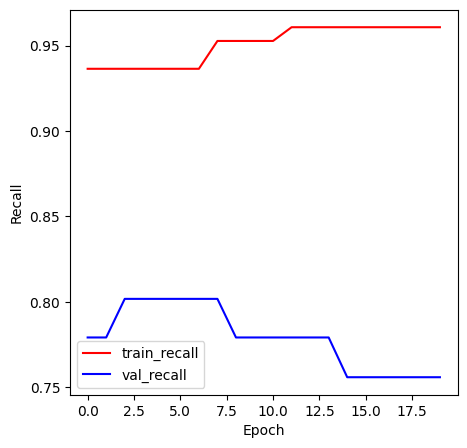

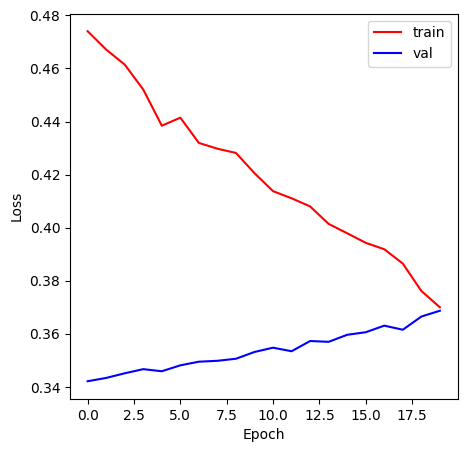

In [52]:
#Model validation and visualization
tf.random.set_seed(42)
sgd_score = model.evaluate(X11_test, y_test, verbose=1)
print('Test recall:', sgd_score[1])
print('Test loss:', sgd_score[0])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(base.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Recall')
ax.legend()
ax.tick_params()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['loss']), 'r', label='train')
ax.plot(np.sqrt(base.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.tick_params()

**RMSprop Optimizer**

In [48]:
#Define a baseline neural network with two layers
#Loss functionand scoring selected for binary classification
#Testing RMSprop optimizer with default values

#Define model
model = Sequential([
        Dense(100, activation = 'relu'),
        Dense(1, activation = 'sigmoid')])

#Compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['recall'])
class_weight={0: 1, 1: 20}

In [49]:
#Fit the model and view scores
#Batch size set by number of columns in X11_train
tf.random.set_seed(42)
base = model.fit(X11_train, y_train,
                 epochs = 20,
                 batch_size = 22,
                 verbose = 0,
                 class_weight=class_weight,
                 validation_data=(X11_test, y_test))
#Score the model
base.history['recall'][-1]

0.8769230842590332

In [53]:
# Calculate AUC score
tf.random.set_seed(42)
y_pred_probs = model.predict(X11_test)
rmsprop_auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {rmsprop_auc_score}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8783880171184023


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1276 - recall: 0.5307
Test recall: 0.5714285969734192
Test loss: 0.1359615921974182


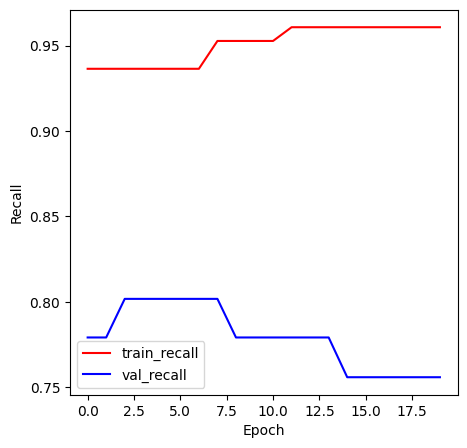

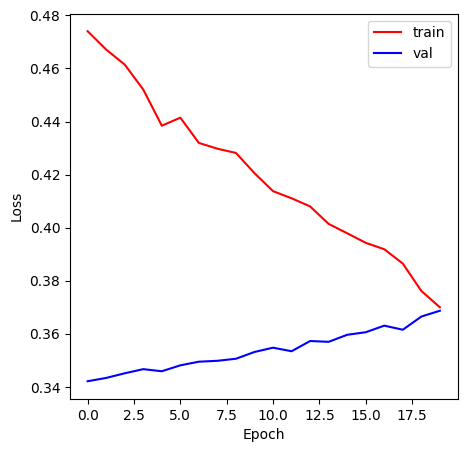

In [54]:
#Model validation and visualization
tf.random.set_seed(42)
rmsprop_score = model.evaluate(X11_test, y_test, verbose=1)
print('Test recall:', rmsprop_score[1])
print('Test loss:', rmsprop_score[0])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(base.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Recall')
ax.legend()
ax.tick_params()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['loss']), 'r', label='train')
ax.plot(np.sqrt(base.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.tick_params()

**ADAM Optimizer**

In [55]:
#Define a baseline neural network with two layers
#Loss functionand scoring selected for binary classification
#Testing RMSprop optimizer with default values

#Define model
model = Sequential([
        Dense(100, activation = 'relu'),
        Dense(1, activation = 'sigmoid')])

#Compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['recall'])
class_weight={0: 1, 1: 20}

In [56]:
#Fit the model and view scores
#Batch size set by number of columns in X11_train
tf.random.set_seed(42)
base = model.fit(X11_train, y_train,
                 epochs = 20,
                 batch_size = 22,
                 verbose = 0,
                 class_weight=class_weight,
                 validation_data=(X11_test, y_test))
#Score the model
base.history['recall'][-1]

0.9692307710647583

In [57]:
# Calculate AUC score
tf.random.set_seed(42)
y_pred_probs = model.predict(X11_test)
adam_auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {adam_auc_score}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.9368758915834521


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1126 - recall: 0.4635
Test recall: 0.5714285969734192
Test loss: 0.11016050726175308


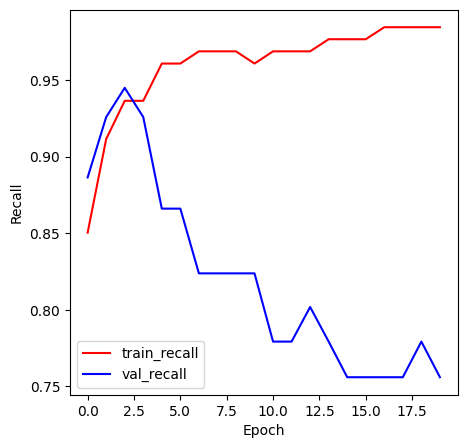

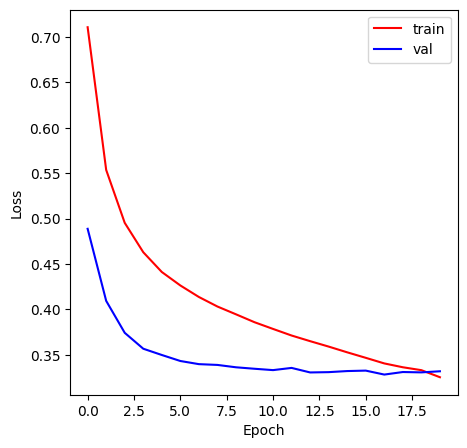

In [58]:
#Model validation and visualization
tf.random.set_seed(42)
adam_score = model.evaluate(X11_test, y_test, verbose=1)
print('Test recall:', adam_score[1])
print('Test loss:', adam_score[0])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(base.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Recall')
ax.legend()
ax.tick_params()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['loss']), 'r', label='train')
ax.plot(np.sqrt(base.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.tick_params()

In [59]:
#Summary table
sgd = ['SGD', sgd_score[1], sgd_score[0], sgd_auc_score]
rmsprop = ['RMSprop', rmsprop_score[1], rmsprop_score[0], rmsprop_auc_score]
adam = ['Adam', adam_score[1], adam_score[0], adam_auc_score]

# Create the DataFrame
summary = pd.DataFrame(data=[sgd, rmsprop, adam],
                      columns=['Optimizer', 'Recall', 'Loss', 'ROC-AUC Score'])

print(summary)

  Optimizer    Recall      Loss  ROC-AUC Score
0       SGD  0.571429  0.135962       0.878388
1   RMSprop  0.571429  0.135962       0.878388
2      Adam  0.571429  0.110161       0.936876


## **Findings**

## **Hyperparameter Tuning**

We will tune some key parameters of the model using GridSearch for:

*   Initialization mode
*   Number of neurons
*   Batch size



In [60]:
# Function to create model, required for KerasClassifier
def create_model(units=32):
    model = Sequential()
    model.add(Dense(units, input_dim=22, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='bce', optimizer='rmsprop', metrics=['recall'])
    return model

# Instantiate the KerasClassifier model
model = KerasClassifier(build_fn=create_model, verbose=1)
class_weight={0: 1, 1: 20}

In [61]:
param_grid = {'batch_size': [10, 22],
              'epochs': [10, 20],
              'model__units': [50, 100, 150]
              }

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, refit=True)
grid.fit(X11_train, y_train)

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_10" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_14" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_16" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_18" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_20" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_22" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_24" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_26" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_28" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_30" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_32" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_34" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_36" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_38" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_40" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_42" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_44" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_46" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_48" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_50" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_52" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_54" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_56" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
    raise ValueError(
ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_58" is incompatible with the layer: expected axis -1 of input shape to have value 22, but received input with shape (None, 23)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 23), dtype=float32)
  • training=True
  • mask=None


In [ ]:
print(grid.best_score_)
grid.best_params_

In [ ]:
from keras import initializers

In [ ]:
#Re-run the model with tuned parameters
model = Sequential()
model.add(Dense(50, input_dim=22, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='bce', optimizer='rmsprop', metrics=['recall'])
class_weight={0: 1, 1: 20}

In [ ]:
tf.random.set_seed(42)
base = model.fit(X11_train, y_train,
                 epochs = 20,
                 batch_size = 22,
                 verbose = 1,
                 class_weight=class_weight,
                 validation_data=(X11_test, y_test))

In [ ]:
# Calculate AUC score
tf.random.set_seed(42)
y_pred_probs = model.predict(X11_test)
adam_auc_score = roc_auc_score(y_test, y_pred_probs)
print(f"AUC: {adam_auc_score}")

In [ ]:
#Model validation and visualization
tf.random.set_seed(42)
adam_score = model.evaluate(X11_test, y_test, verbose=1)
print('Test recall:', adam_score[1])
print('Test loss:', adam_score[0])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['recall']), 'r', label='train_recall')
ax.plot(np.sqrt(base.history['val_recall']), 'b' ,label='val_recall')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Recall')
ax.legend()
ax.tick_params()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(np.sqrt(base.history['loss']), 'r', label='train')
ax.plot(np.sqrt(base.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.legend()
ax.tick_params()